# Using Computer Vision to Remediate Discrepancies in Merchandising Resets
In this python notebook, I will showcase  a powerful application of convolutional neural networks in the domain of merchandising resets. I will train a yoloV3 object detection system to categorize various items in grocery stores. This model will be trained on a dataset that I have been developing myself using an iPhoneXR and the annotation tool LabelImg. The dataset can be accessed here:
  https://www.kaggle.com/alitquanmallick/grocery-classifier



Later on, we also implement a model to predict likely regions of interest that may contain barcodes. This model will be trained on data from Muenster DB which will have undergone processing via Tunistra's Algorithm, a process that I have streamlined using elementary statistics.


# Configuring Kaggle

The following blocks of code will aid you in successfully downloading the dataset.

In [1]:
import os
from google.colab import files

For convenience, the following snippet off code is to upload any files. **In most cases, skip this skippet**

In [2]:
files.upload()

{}

The following snippet creates an isolated directory where all of the code will be executed.

In [3]:
os.chdir('/content')
!pwd # 1st line
!ls  # 2nd line
if os.path.exists('/content/Detection'):
  shutil.rmtree('/content/Detection')
!ls  # 3rd line
!mkdir '/content/Detection'
os.chdir('/content/Detection')
!pwd # 4th line


/content
sample_data
sample_data
/content/Detection


Upload **kaggle.json** which can be downloaded from your user settings at https://www.kaggle.com/  . Note that **You have to do this if you want to download the dataset**

In [4]:
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!ls

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 71 Dec  8 07:55 kaggle.json
kaggle.json


Copying the JSON file which it is expected to be in by the kaggle command

In [5]:
!pwd
!ls
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd
!ls
!chmod 600 /root/.kaggle/kaggle.json
!pwd

/content/Detection
kaggle.json
/content/Detection
kaggle.json
/content/Detection


Downloading my custom dataset, which consists of:

*   resized images and corresponding XML annotations of grocery store items, labeled by class of product 
*   resized images and corresponding XML annotations of grocery store items, labeled by individual product
*   vanilla images of shelves that have UPC barcodes
*   vanilla images of shelves with UPC codes

All annotations were made using LabelIMG

In [6]:
!kaggle datasets download -d alitquanmallick/grocery-classifier
!ls

 98% 889M/909M [00:06<00:00, 103MB/s]
100% 909M/909M [00:06<00:00, 141MB/s]
grocery-classifier.zip	kaggle.json


In [7]:
!unzip  grocery-classifier.zip
!mkdir KaggleStuff
!cp -r '/content/Detection/Grocery by Class/Grocery by Class' ./KaggleStuff
!cp -r '/content/Detection/Grocery by Product/Grocery by Product' ./KaggleStuff
!cp -r '/content/Detection/Vanilla Barcodes/Vanilla Barcodes' ./KaggleStuff
!cp -r '/content/Detection/Vanilla Barcodes/Processed Shelves' ./KaggleStuff
!rm -rd '/content/Detection/Grocery by Class/'
!rm -rd '/content/Detection/Grocery by Product/'
!rm -rd '/content/Detection/Vanilla Barcodes/'
!rm -rd '/content/Detection/Processed Shelves/'
!rm grocery-classifier.zip 

Archive:  grocery-classifier.zip
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2099.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2100.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2101.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2102.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2103.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2104.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2105.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2106.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2107.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2108.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2109.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2110.xml  
  inflating: Grocery by Class/Grocery by Class/Annotations/IMG_2111.xml  
  inf

##Viewing the Dataset
To view the images with annotations, it is imperative that you view them using **labelimg** (https://github.com/tzutalin/labelImg). If not a Windows user, follow the resources there.

If using Windows type:
*pip install labelimg*
into the command prompt

After downloading the datasets onto your machine (not Colab), select the dataset you want to go to. Enter the dataset such that *'Resized Images'* and *'Annotations'* are in the same folder. 
Take note of the path and launch labelimg by typing *labelimg* into the command prompt. Then select **'open dir'** and navigate to noted path. Select the folder *'Resized Images'*. Next, click '**Change Save Dir**' and select the folder *'Annotations'* in the same directory.


#Visualizing Tunistra's Algorithm

Tunistra's Algorithm is an algorithm that was designed to estimate the gradient of a barcode by using the Sobel kernel to calculate the X and Y derivatives. Then thresholding, erosion, and morphological dilation produce binarized segments that represent candidates that may be barcode regions.

In [8]:
!apt install libzbar0
!pip install pyzbar
import numpy as np
import pandas as pd
import math
import cv2 as cv 
import imutils
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from scipy import ndimage as nd
from skimage.filters import roberts, sobel, scharr, prewitt
from google.colab import drive
from pyzbar import pyzbar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libv4l-0 libv4lconvert0
The following NEW packages will be installed:
  libv4l-0 libv4lconvert0 libzbar0
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 193 kB of archives.
After this operation, 760 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libv4lconvert0 amd64 1.14.2-1 [76.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libv4l-0 amd64 1.14.2-1 [41.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libzbar0 amd64 0.10+doc-10.1build2 [75.7 kB]
Fetched 193 kB in 1s (288 kB/s)
Selecting previously unselected package libv4lconvert0:amd64.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libv4lconvert0_1.14.2-1_amd64.deb ...
Unpacking libv4lconvert0:amd64 (1.14.2-1) ...
Selecting p

The following snippet of code selects the first image of the original UPC image, although this image is not resized

In [9]:
image ='/content/Detection/KaggleStuff/Vanilla Barcodes/IMG_1600.jpg'
img = cv.imread(image)
original = img.copy()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

Processing according to Tunistra's Algorithm

In [10]:

gaus = cv.GaussianBlur(img,(3,3),cv.BORDER_DEFAULT)
canny = cv.Canny(gaus,50,150,apertureSize=3)

'''
-------- Tunistra's Algorithm ------
'''
# derivatives across the X and Y axes
gradX = cv.Sobel(gray,cv.CV_64F,dx=1,dy=0,ksize=-1)
gradY = cv.Sobel(gray,cv.CV_64F,dx=0,dy=1,ksize=-1)

# subtracting Y derivative from the X-derivative
gradient = cv.subtract(gradX,gradY)
gradient = cv.convertScaleAbs(gradient)

# applying gaussian blur and thresholding
blurred = cv.blur(gradient,(9,9))
(_,thresh) = cv.threshold(blurred,225,255,cv.THRESH_BINARY)

# applying a structuring element across the resulting image
kernel = cv.getStructuringElement(cv.MORPH_RECT,(21,7))
closed = cv.morphologyEx(thresh,cv.MORPH_CLOSE,kernel)

# applying erosions gets rid of noise
erode   = cv.erode(closed,None,iterations = 4)

# dilations emphasize fragments that are more probably important
dilated = cv.dilate(erode,None,iterations = 4)

##Phases of the Algorithm

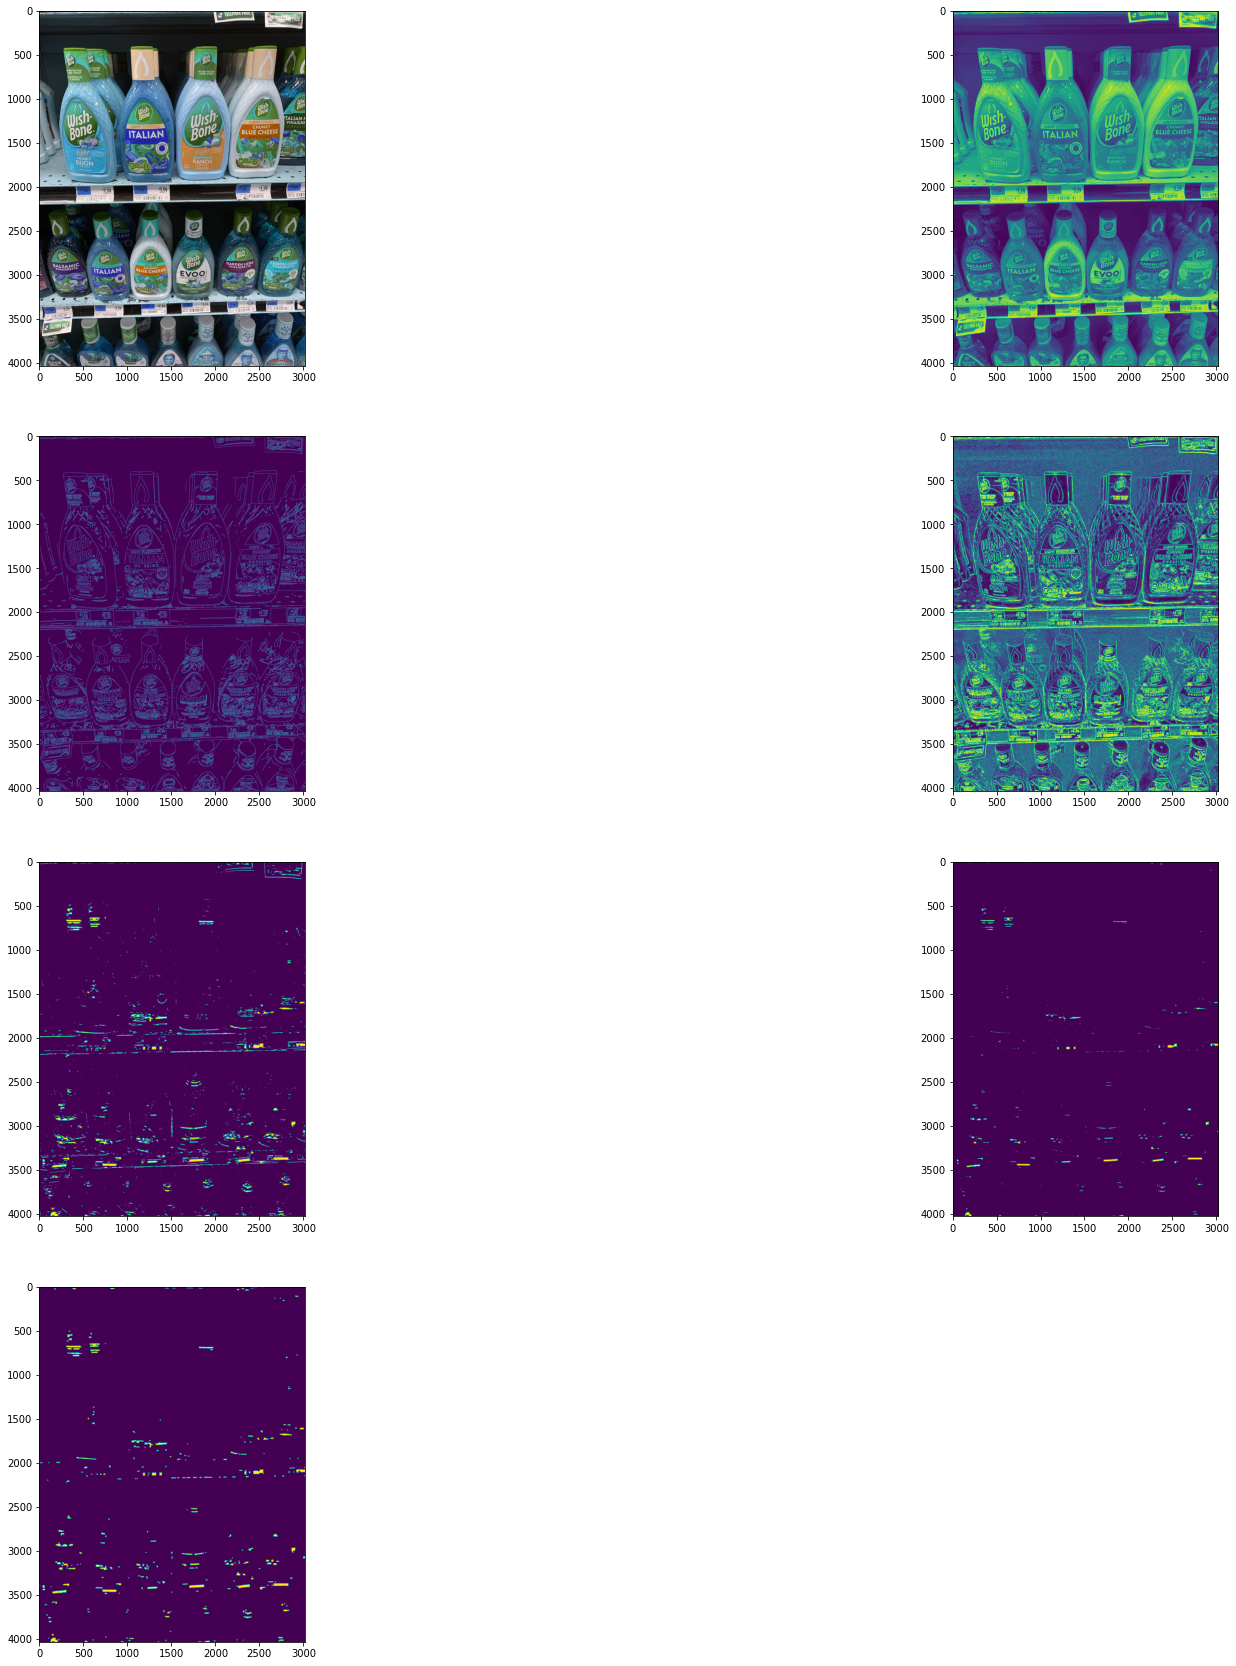

In [11]:
'''
-----------DISPLAYING---PHASES--------------
'''
fig = plt.figure(figsize = (30,30))
displayRows = 4
displayCols = 2
position = 1


filters = list()

filters.append(img)
filters.append(gray)
filters.append(canny)
filters.append(gradient)
filters.append(closed)
filters.append(erode)
filters.append(dilated)


for filter in filters:
  plt.subplot(displayRows,displayCols,position)
  plt.imshow(filter)
  position = position + 1

##Displaying the Resulting Contours
Below is some code that sorts the contours based on size and then displays the largest *i* contours, where *i* is represented by the variable *biggest*. This variable is arbitrarily chosen in this block of code. 

As can be seen below, contours that are really just noise, at times take precedence over UPC barcodes. This is problematic, because it increases the search space when trying to decode barcodes, and also because some barcodes may not be detected if the number of contours arbitrarily chosen to examine is too low.


In [ ]:


'''
===============CONTOURING==================
'''

'''
Each member in contour info holds
  minimum X coordinate of rectangle
  maximum X coordinate of rectangle
  minimum Y coordinate of rectangle
  maximum Y coordinate of rectangle
'''
contourInfo = list()

cnts = cv.findContours(dilated.copy(),cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# contours are sorted
sorted_cont = sorted(cnts,key = cv.contourArea,reverse=True)

biggest = 15 # arbitrary number for now


for i in range(biggest):
  rect = cv.minAreaRect(sorted_cont[i])
  box = cv.boxPoints(rect) if imutils.is_cv2() else cv.boxPoints(rect)
  box = np.int0(box)

  '''
  Extracting point information for regions of interests
  '''
  #setting to arbitrary values
  bcXmin = box[0][0]
  bcXmax = box[0][0]
  bcYmin = box[0][1]
  bcYmax = box[0][1]

  for corner in box:
    if corner[0] < bcXmin:
      bcXmin = corner [0]
    if corner[0] > bcXmax:
      bcXmax = corner [0]
    if corner[1] < bcYmin:
      bcYmin = corner [1]
    if corner[1] > bcYmax:
      bcYmin = corner [1]
  
  #print ("BOX: {} B XMIN: {} B XMAX: {} B YMIN: {} B YMAX: {}".format(box,bcXmin,bcXmax,bcYmin,bcYmax))
  contourInfo.append( (bcXmin,bcXmax,bcYmin,bcYmax) )

  cv.drawContours(img,[box],-1,(0,255,0),3)
  cv.waitKey(0)

[(2644, 2834, 3365, 3393), (1706, 1876, 3379, 3417), (2433, 2551, 2070, 2125), (716, 883, 3436, 3462), (148, 315, 3439, 3483), (2241, 2398, 3374, 3422), (576, 686, 638, 677), (309, 479, 665, 685), (2923, 3023, 2068, 2105), (133, 214, 3984, 4031), (1325, 1452, 1766, 1792), (1817, 1981, 677, 697), (1232, 1344, 3402, 3428), (1051, 1186, 1738, 1772), (2738, 2875, 1664, 1684)]
<PIL.Image.Image image mode=RGB size=266x104 at 0x7F8A11186B38>


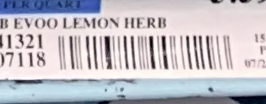

<PIL.Image.Image image mode=RGB size=246x114 at 0x7F8A111860B8>


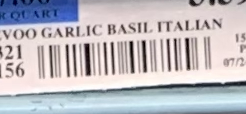

<PIL.Image.Image image mode=RGB size=194x131 at 0x7F8A11186A58>


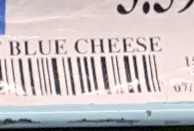

<PIL.Image.Image image mode=RGB size=243x102 at 0x7F8A11186EB8>


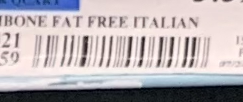

<PIL.Image.Image image mode=RGB size=243x120 at 0x7F8A11186A58>


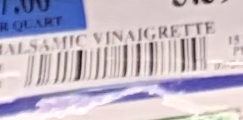

<PIL.Image.Image image mode=RGB size=233x124 at 0x7F8A11186EB8>


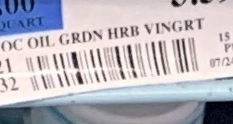

<PIL.Image.Image image mode=RGB size=186x115 at 0x7F8A11186A58>


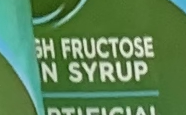

<PIL.Image.Image image mode=RGB size=246x96 at 0x7F8A11186EB8>


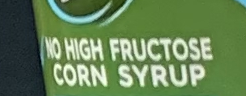

<PIL.Image.Image image mode=RGB size=139x113 at 0x7F8A11186A58>


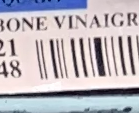

<PIL.Image.Image image mode=RGB size=157x86 at 0x7F8A11186EB8>


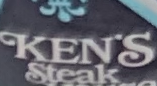

<PIL.Image.Image image mode=RGB size=203x102 at 0x7F8A11186A58>


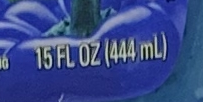

<PIL.Image.Image image mode=RGB size=240x96 at 0x7F8A11186EB8>


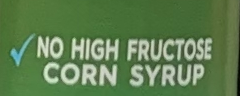

<PIL.Image.Image image mode=RGB size=188x102 at 0x7F8A11186A58>


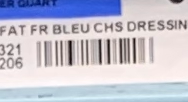

<PIL.Image.Image image mode=RGB size=211x110 at 0x7F8A11186EB8>


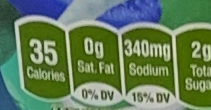

<PIL.Image.Image image mode=RGB size=213x96 at 0x7F8A11186A58>


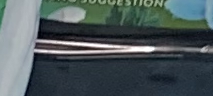

In [ ]:
'''
============ EXTRACTING BARCODES ============
'''
#some leeway for the cropping
bufferSpace = 38
example = 1
print (contourInfo)

candidates = list()
for i in range(biggest): 
  cropX1 = contourInfo[i][0]
  cropX2 = contourInfo[i][1]
  cropY1 = contourInfo[i][2]
  cropY2 = contourInfo[i][3]

  # crops the image 
  cropped = original[cropY1-bufferSpace:cropY2+bufferSpace, cropX1 - bufferSpace:cropX2 + bufferSpace]

  #print(cropped)

  #potential barcode candidates
  candidates.append( cropped)


  #displays the cropped image
  cropped = Image.fromarray(cropped)
  print(cropped)
  display(cropped)

### The Problem of Noise
To illustrate flaws related to generated noise from the environment, check out the examples in the section titled **Flaws of the Algorithm**

##Observing Histogram Intensities
Due to the fact that UPC tags are on the same horizontal plane due to the nature of the shelf, these regions can be isolated if we calculate mean intensity pixel per row in an image.

The following blocks of code illustrate how that can be done. Our intention is to use this isolation to either 


*   Train the model on denoised images to see if this will improve accuracy of contour classification OR
*   To run the model on denoised images to see if more accurate results are accomplished



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


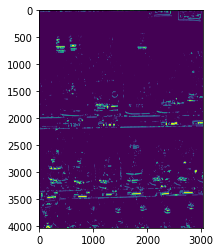

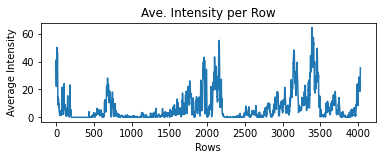

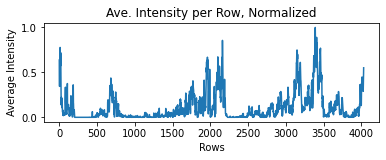

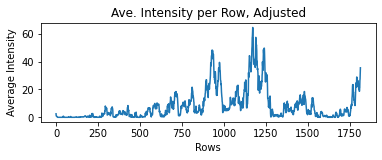

In [12]:
from sklearn.preprocessing import minmax_scale
'''
========== HISTOGRAM ===========
'''

# Collecting average pixel intensity over each row 
houghNP = np.array(closed)
rows= houghNP.mean(axis=1)

#Getting the Number of columns
cols= len(houghNP[0])

plt.imshow(closed)

# Plotting the first graph

fig,axs = plt.subplots(2,1) # 1 row and 2 columns
axs.flat[-1].set_visible(False)  #hides extra graph
axs[0].plot(rows)
axs[1].plot(cols)
axs[0].set_title("Ave. Intensity per Row")
axs[0].set_xlabel("Rows")
axs[0].set_ylabel("Average Intensity")

fig.show()

'''
MIN-MAX NORMALIZATION
'''
fig,axs = plt.subplots(2,1) # 1 row and 2 columns
axs.flat[-1].set_visible(False)  #hides extra graph
array_temp = np.copy(rows)
axs[0].plot( minmax_scale (array_temp))
axs[1].plot(len(array_temp))
axs[0].set_title("Ave. Intensity per Row, Normalized")
axs[0].set_xlabel("Rows")
axs[0].set_ylabel("Average Intensity")
fig.show()

'''
MODIFIED: zeroes are removed from the array
'''
intensity_average = 0.5 * (np.mean(rows))

modified_rows = np.copy(rows)

for row in rows:
  if (row < intensity_average):
    modified_rows = np.delete(modified_rows,row)

fig,axs = plt.subplots(2,1) # 1 row and 2 columns
axs.flat[-1].set_visible(False)  #hides extra graph
axs[0].plot(modified_rows)
axs[1].plot(len(modified_rows))
axs[0].set_title("Ave. Intensity per Row, Adjusted")
axs[0].set_xlabel("Rows")
axs[0].set_ylabel("Average Intensity")
fig.show()



## Isolating Barcode Regions to Reduce Noise

As can be seen from the above display, due to the fact that the the edges of the the shelves, lines of the bars on the UPC barcodes, and various textures of merchandise are more prominent than the foreground, isolating these regions can reduce the noise created by inaccuracies.

By reducing eliminating noise in each of these images, there will be less room for misclassification, as the search space in the images is reduced. Intuitively, a model trained on images with less noise may perform better at classifying these contours. Or perhaps, simply training a model on noisy images and then testing it out on these denoised images may result in a more accurate model.

8.356446825834581
11.024296406370258


Peak Ranges
1947
2167
3139
3476


Peak Ranges with Buffer Added or Subtracted

1847
2267
3039
3576
[[1847, 2267], [3039, 3576]]





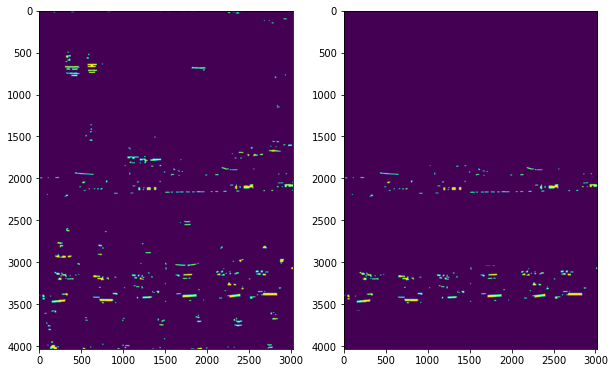

In [13]:
'''
=========== GETTING UPC REGIONS =============
'''

'''
-----------DISPLAYING---PHASES--------------
'''
fig = plt.figure(figsize = (10,10))
displayRows = 1
displayCols = 2
position = 1


filters = list()


# Average and Standard Deviation excluding zeroes
mod_int_ave = np.mean(modified_rows)
mod_int_std = np.std(modified_rows)
print (mod_int_ave)
print (mod_int_std)

intensity_threshold = mod_int_ave + ( 2 * mod_int_std)

counter = 0
relev_rows = list() #rows that are above threshold
peaks = list()


# Significant rows are added to a list, because they 
#   are most likely barcode regions of the shelves
for row in rows:
  if (row > intensity_threshold):
    relev_rows.append(counter)
    #print(counter)
  counter = counter + 1 


# Iterates across the significant rows, compiling a list 
#   of start and endpoints for likely barcode regions
for i, point in enumerate(relev_rows):

  if i == 0:
    continue

  if abs(point - relev_rows[i-1]) > 200:
    peaks.append(relev_rows[i-1])
    peaks.append(point)

# removes 1st and last elements from the list, which are irrelevant
peaks.pop(0)
peaks.pop(len(peaks)-1)


print ("\n\nPeak Ranges")
for peak in peaks:
  print(peak)

# Adds or subtracts a buffer, giving leeway for 
#   successfully detecting a region with barcode
#   numbers
shelf_buffer = 100
for start in range (0,len(peaks),2):
  peaks[start] = peaks[start] - shelf_buffer
  peaks[start+1] = peaks[start+1] + shelf_buffer


print("\n\nPeak Ranges with Buffer Added or Subtracted\n")
for peak in peaks:
  print(peak)

'''
Reorganizes list into tuples, as designated
  @param mylist       the list to be split
  @param chunk_size   size of each member in new list   
'''
def SplitList(mylist, chunk_size):
    return [mylist[offs:offs+chunk_size] for offs in range(0, len(mylist), chunk_size)]


# peaks now consists of tuples as such:
#   (first row of barcode region, last row of barcode region)
peaks = SplitList(peaks,2)
print(peaks)

dilated_data = np.array(dilated)
dilated_length = len(dilated_data)
row_length = len(dilated_data[0])
half_point = int(dilated_length/2)

# barcode regions is a copy of the image during the dilation phase
barcode_regions = dilated.copy()
print()
filters.append(barcode_regions.copy())

# setting barcode regions entirely black
for i in range(dilated_length):
  barcode_regions[i] = np.zeros (row_length)
print()


'''
Copies regions from an image onto another
  @param  orig         the original image
  @param  copy         the image to where something is being copied
  @param  reg_tuples   2D tuples, wheres 1st dimension represents
                       starting row and the 2nd dimension represents 
                       the last row
'''
def extractBarcodeRegions (orig,copy,reg_tuples):
  for tup in reg_tuples:

    # test statement
    if len(tup) != 2:
      print("Error: refer extractBarcodeRegions")
      break
    
    for i in range (tup[0],tup[1]):
      copy[i] = orig[i]

'''
  relevant regions of dilate that contain UPC codes are
  copied onto barcode_regions, which hitherto was black
'''
extractBarcodeRegions(dilated,barcode_regions,peaks)

print()
filters.append(barcode_regions)


for filter in filters:
  plt.subplot(displayRows,displayCols,position)
  plt.imshow(filter)
  position = position + 1

##Converting Images on Mass

To apply Tunistra's Algorithm to all of the photos, we use Python's OOP. **This section is not important and is inconsequential in understanding this paper**

In [20]:
# path for downloading images
on_mass       = "Conversion Demo"
tunistra_path = on_mass + "/Tunistra"
denoised_path = on_mass + "/Denoised"

if not (os.path.exists(on_mass)):
  os.mkdir(on_mass)

if not (os.path.exists(tunistra_path)):
  os.mkdir(tunistra_path)

if not (os.path.exists(denoised_path)):
  os.mkdir(denoised_path)



class Converter:
  filters = list()
  path    = ""


  
  def __init__(self,string):
    self.path    = string
    self.filters = list()

  def tunistraPreprocessing(self):
    img = cv.imread(self.path)
    original = img.copy()
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # smoothing
    gaus = cv.GaussianBlur(img,(3,3),cv.BORDER_DEFAULT)
    #canny edge detection
    canny = cv.Canny(gaus,50,150,apertureSize=3)

    # derivatives across the X and Y axes
    gradX = cv.Sobel(gray,cv.CV_64F,dx=1,dy=0,ksize=-1)
    gradY = cv.Sobel(gray,cv.CV_64F,dx=0,dy=1,ksize=-1)


    # subtracting Y derivative from the X-derivative
    gradient = cv.subtract(gradX,gradY)
    gradient = cv.convertScaleAbs(gradient)

    # applying gaussian blur and thresholding
    blurred = cv.blur(gradient,(9,9))
    (_,thresh) = cv.threshold(blurred,225,255,cv.THRESH_BINARY)


    kernel = cv.getStructuringElement(cv.MORPH_RECT,(21,7))
    closed = cv.morphologyEx(thresh,cv.MORPH_CLOSE,kernel)

    erode   = cv.erode(closed,None,iterations = 4)
    dilated = cv.dilate(erode,None,iterations = 4)

    chosen_filter = cv.cvtColor(dilated, cv.COLOR_GRAY2BGR)
    cv.imwrite(os.path.join (tunistra_path,os.path.basename(self.path)),chosen_filter.astype(np.uint8))

    self.filters.append(img)      #0 
    self.filters.append(gray)     #1
    self.filters.append(canny)    #2
    self.filters.append(gradient) #3
    self.filters.append(closed)   #4
    self.filters.append(erode)    #5
    self.filters.append(dilated)  #6


  def display(self,_displayRows, _displayCols, _array = None):
    if _array == None: 
      _array = self.filters

    fig = plt.figure (figsize = (30,30))
    position = 1

    for filter in _array:
      plt.subplot(_displayRows,_displayCols,position)
      plt.imshow(filter)
      position = position + 1
  
  def display(self):
 
    _array = list()
    _array.append (self.filters[0])
    _array.append (self.filters[6])

    fig = plt.figure (figsize = (10,10))
    position = 1

    for filter in _array:
      plt.subplot(2,2,position)
      plt.imshow(filter)
      position = position + 1
  
  '''
  Reorganizes list into tuples, as designated
    @param mylist       the list to be split
    @param chunk_size   size of each member in new list   
  '''
  def SplitList(self,mylist, chunk_size):
      return [mylist[offs:offs+chunk_size] for offs in range(0, len(mylist), chunk_size)]

  def getPeaks(self, show = False, save = False):

    #1st graph
    houghNP = np.array(self.filters[5])
    rows    = houghNP.mean(axis=1)
    cols    = len(houghNP[0])


    if (show):
      fig,axs = plt.subplots(2,1) # 1 row and 2 columns
      axs.flat[-1].set_visible(False)  #hides extra graph
      axs[0].plot(rows)
      axs[1].plot(cols)
      axs[0].set_title("Ave. Intensity per Row")
      axs[0].set_xlabel("Rows")
      axs[0].set_ylabel("Average Intensity")
      
      fig.show()
    
      print()
      print()
      print()

    #2nd graph: excludes rows below intensity_average
    intensity_average = 0.25 *(np.mean(rows))
    modified_rows     = np.copy(rows)

    # deleting rows below intensity average
    for row in rows:
      if (row < intensity_average):
        modified_rows = np.delete(modified_rows,row)
   
    if (show):
      fig,axs = plt.subplots(2,1) # 1 row and 2 columns
      axs.flat[-1].set_visible(False)  #hides extra graph
      axs[0].plot(modified_rows)
      axs[1].plot(len(modified_rows))
      axs[0].set_title("Ave. Intensity per Row, Adjusted")
      axs[0].set_xlabel("Rows")
      axs[0].set_ylabel("Average Intensity")
      fig.show()
    
    # Average and Standard Deviation excluding zeroes
    mod_int_ave = np.mean(modified_rows)
    mod_int_std = np.std(modified_rows)
    if (show):
      print (f'average intensity of thresholded rows: {mod_int_ave}')
      print (f'average standard deviation of thresholded rows: {mod_int_std}')
    intensity_threshold = mod_int_ave + ( 1.15 * mod_int_std)

    counter = 0
    relev_rows = list() #rows that are above threshold
    peaks = list()


    # Significant rows are added to a list, because they 
    #   are most likely barcode regions of the shelves
    for row in rows:
      if (row > intensity_threshold):
        relev_rows.append(counter)
        #print(counter)
      counter = counter + 1 


    # Iterates across the significant rows, compiling a list 
    #   of start and endpoints for likely barcode regions
    for i, point in enumerate(relev_rows):

      if i == 0:
        continue

      if abs(point - relev_rows[i-1]) > 100:
        peaks.append(relev_rows[i-1])
        peaks.append(point)

    # removes 1st and last elements from the list, which are irrelevant
    peaks.pop(0)
    peaks.pop(len(peaks)-1)


    # Adds or subtracts a buffer, giving leeway for 
    #   successfully detecting a region with barcode
    #   numbers
    shelf_buffer = 50
    for start in range (0,len(peaks),2):
      peaks[start] = peaks[start] - shelf_buffer + 10
      peaks[start+1] = peaks[start+1] + shelf_buffer

    # peaks now consists of tuples as such:
    #   (first row of barcode region, last row of barcode region)
    peaks = self.SplitList(peaks,2)


    return peaks


 
  def extractBarcodeRegions(self, show = False, save = False):
    # images to be displayed
    examples = list()
    examples.append(self.filters[0])
    img          = self.filters[6].copy()
    img_as_array = np.array(img)
    num_rows     = len(img_as_array)
    row_length   = len(img_as_array[0])

    # barcode regions is a copy of the image during the dilation phase
    barcode_regions = img.copy()
    examples.append(barcode_regions.copy())

    
      
    # setting barcode regions entirely black
    for i in range(num_rows):
      try:
        barcode_regions[i] = np.zeros ((row_length,3))
      except ValueError:
        barcode_regions[i] = np.zeros (row_length)
    
    examples.append(Image.fromarray(barcode_regions))

    for tup in self.getPeaks():
      if len(tup) != 2:
        print("Error: refer extractBarcodeRegions")
        break
    
      for i in range(tup[0],tup[1]):
        barcode_regions[i] = img[i]

    examples.append(barcode_regions)

    if (show):
      fig = plt.figure (figsize = (30,30))
      position = 1

      for filter in examples:
        plt.subplot(2,3,position)
        plt.imshow(filter)
        position = position + 1
    
    # saves path to a new directory if indicated by parameters
    if (save):
       barco = cv.cvtColor(barcode_regions, cv.COLOR_GRAY2BGR)
       cv.imwrite(os.path.join (denoised_path, os.path.basename(self.path)),barco.astype(np.uint8))

  

This snippet of code pre-processes all of the vanilla images and stores them in the directory *Conversion Demo*. Using this method was how the dataset *Processed Shelves* in *KaggleStuff* was created.

In [28]:
orig_path     = "/content/Detection/KaggleStuff/Vanilla Barcodes"
for image in os.listdir(orig_path):
    temp_path = os.path.join(orig_path,image)
    temp = Converter(temp_path)
    temp.tunistraPreprocessing()
    temp.extractBarcodeRegions(save = True)
    del temp
    del temp_path

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


##Flaws of the Algorithm


For certain transparent/transluscent materials, reflection of light results in a patterns of lines that end up creating the same contours as UPC tags. 

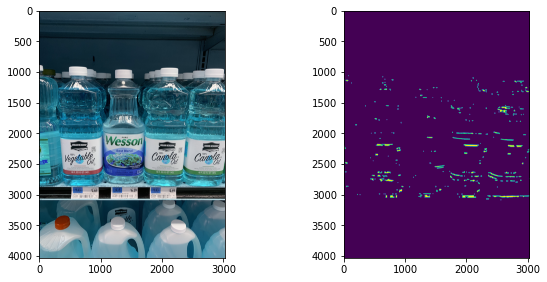

In [27]:
example = Converter('/content/Detection/KaggleStuff/Vanilla Barcodes/IMG_1603.jpg')
example.tunistraPreprocessing()
example.display()

When images are taken from a distance, the image is more detail-dense, meaning that more lines are apparent in the image. Thus, When processed according to Tunistra's Algorithm, more contours are detected, especially with the aforementioned reflections. Additionally, it should be noted that dense writing is often interpreted the same way as the bars in UPC tags are, similarly misconstruing the results.

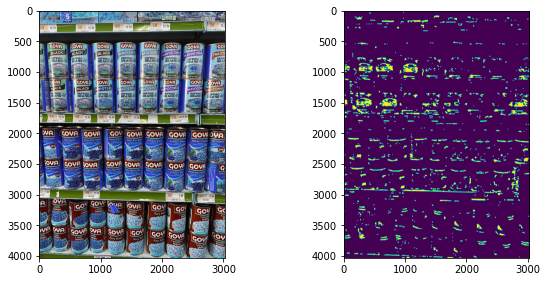

In [23]:
example = Converter('/content/Detection/KaggleStuff/Vanilla Barcodes/IMG_2790.JPG')
example.tunistraPreprocessing()
example.display()

As can be seen on the first row of tags, wear-and-tear significantly impacts the creation of contours. It should also be noted that the protrusion of the shelf over the barcodes also impacts the ability to make contours. Hence, the orientation by which the images are taken is important.

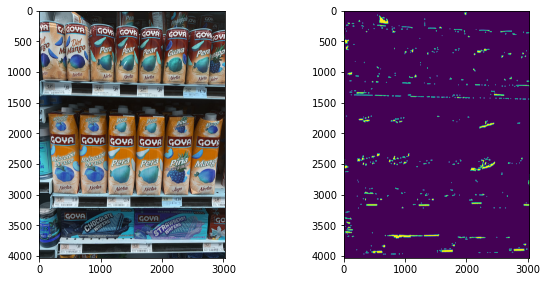

In [21]:
example = Converter('/content/Detection/KaggleStuff/Vanilla Barcodes/IMG_1608.jpg')
example.tunistraPreprocessing()
example.display()

With certain material, such as plastic, reflections from the lights result in segments of the image that are much similar to the contours of the bar in Tunistra's Algorithm

In [ ]:
img = "/content/Detection/KaggleStuff/Vanilla Barcodes/IMG_2734.JPG"
img = cv.imread(image)

#Training the Model


Basic framework for training a YOLOv3 model. This section was used for training all of the models. Only changes have to be made to the *training()* function to train the model on a different dataset. Some blocks may not be run because the models may have already been trained.

In [29]:
%tensorflow_version 1.13
import tensorflow
print(tensorflow.__version__)
!pip install imageai
import os 
import glob
import csv
import re
import pandas as pd 
import xml.etree.ElementTree as ET
import imageio
import shutil
import random
from PIL import Image
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBoxesOnImage
from imageai.Detection.Custom import DetectionModelTrainer

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2
     |████████████████████████████████| 184kB 6.2MB/s 


Using TensorFlow backend.


Basic paths that we will be using. The './' implies the current directory.

In [30]:
'''
    PATH CONSTANTS
'''
_resizePath= './Resized Images/'
_annotPath = './Annotations/'
_dataSet   = './Dataset/'
_removed   = './Removed/'
_csv       = './XML as CSV/'

Housekeeping functions that are used primarily to ensure consistency with the annotations and the images.

In [31]:
'''
    Resizes all the images in the directory with path 'origPath'
    and saves them into the directory with path 'resizePath'

    Note that origPath must exist before
'''

def imageResize (origPath,resizePath):
    width = 410
    height = 450

    if not (os.path.exists(resizePath)):
        os.makedirs(resizePath)

    for image in os.listdir(origPath):
        orig = Image.open (origPath + image)
        new = orig.resize((width,height))
        # new = new.rotate(270)
        new.save(resizePath + image)


'''
    Recursively deletes all paths in a directory
'''
def deleteDirectories (paths):
    for _path in paths:

        if not os.path.exists(_path):
            continue

        shutil.rmtree(_path)


'''
    Removes all files of a particular format 'ext' from 
        directory with path 'pathToDir'

    Note: extension does not need to be preceded with 
        a period
'''
def remExtFromDirectory (pathToDir,ext):
    files = glob.glob(pathToDir + f'/*{ext}')

    for file in files:
        os.chmod(file, 0o777) # allows permission
        os.remove(file)

'''
    Removes all files of a particular prefix 'pref' from 
        directory with path 'pathToDir'
'''
def remPrefFromDirectory (pathToDir,pref):
    files = glob.glob(pathToDir + f'/{pref}*')

    for file in files:
        os.chmod(file, 0o777) # allows permission
        os.remove(file)

'''
    Checks all of the images
'''
def checkImages(directories):
    for directory in directories:
        imgs_names = glob.glob(directory+'/*.jpg')
        for imgname in imgs_names:
            img = cv.imread(imgname)
            if img is None:
              print(imgname)
'''
    Standardizes file extensions
'''
def rename (directory):
	for img_file in os.listdir(directory):
		if (img_file[-4:] != ".jpg"):
			file_path = os.path.join(directory,img_file)
			new_path  = file_path[:-4]+".jpg"
			print (f'{img_file} \t {new_path}')
			os.rename(file_path,new_path)



During image augmentation, we need to be able to readily access data from the original labels and then reconstruct the labels to accommodate the generated images. These functions will help to do that.

Credit is due to datitran @ https://github.com/datitran
for the functions xml_to_csv() and csv_to_xml(), which I have only made slight changes to compensate for a few anomalies that arise in later functions.

In [32]:

'''
    Intended to use on directory with XML annotations
        for testing images

    Parses XML and creates a dataframe with information 
        for each label
'''
def xml_to_csv (path):
    xml_list = []

    # retrieves all xml files in path
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # goes through each object, which in this case refers to lables
        for member in root.findall('object'):

            try:

                value = (root.find('filename').text, 
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        member[0].text,
                        float(member[4][0].text),
                        float(member[4][1].text),
                        float(member[4][2].text),
                        float(member[4][3].text)
                        )
                xml_list.append(value)

            except TypeError:
                train_path  = './Dataset/train/'
                validation_path = './Dataset/validation/'
                print(member)
                print(xml_file)
                head,tail = os.path.split(xml_file)
                # print (f'Head: {head}')
                # print (f'Tail: {tail}')
                xml_file = tail
                print('Error was with: ' + xml_file, end = "\t")
                print("Removing this file from all dataset directories")

                train_path_images = train_path + 'images/'+ xml_file.replace(".xml",".jpg")
                train_path_annotations = train_path + 'annotations/'+ xml_file
                valid_path_images = validation_path + 'images/'+ xml_file.replace(".xml",".jpg")
                valid_path_annotations = validation_path + 'annotations/'+ xml_file

                if os.path.exists(train_path_images): 
                    os.remove(train_path_images)
                
                if os.path.exists(train_path_annotations):                 
                    os.remove(train_path_annotations)

                if os.path.exists(valid_path_images): 
                    os.remove(valid_path_images)

                if os.path.exists(valid_path_annotations):                   
                    os.remove(valid_path_annotations)


    # corresponds to each item in the tuple 'value' above
    column_name = ['filename','width','height','class','xmin','ymin','xmax','ymax']
    xml_df = pd.DataFrame(xml_list, columns = column_name)
    return xml_df


'''
stores xml as csv as text file as specified by
parameters

param
    @annotPath --- path with xml files
    @name      --- name to save csv file under
    @storePath --- directory to save csv file in
'''
def xml_to_csv_file(annotPath, name, storePath):
    temp = xml_to_csv (annotPath)
    temp.to_csv (storePath + f'/{name}.txt')


def csv_to_xml (csv_path,resized_images_path,labels_path,folder):

    # opens path for reading
    f = open (csv_path,'r')

    # reads file as csv file
    reader = csv.reader(f)
    header = next(reader)   #row with all the columns?
    old_filename = None

    for row in reader:
        filename = row[0]
        if filename == old_filename:
          

            object = ET.SubElement(annotation,'object')
            ET.SubElement(object,'name').text = row[3]
            ET.SubElement(object,'pose').text = 'Unspecified'
            ET.SubElement(object,'truncated').text = '0'
            ET.SubElement(object,'difficult').text = '0'

            bndbox = ET.SubElement(object,'bndbox')
            ET.SubElement(bndbox,'xmin').text = row[4]
            ET.SubElement(bndbox,'ymin').text = row[5]
            ET.SubElement(bndbox,'xmax').text = row[6]
            ET.SubElement(bndbox,'ymax').text = row[7]
            # print (f'Filename == old_filename: {filename}')

        else:

            if old_filename is not None:
                labels_file = old_filename.replace('.jpg','.xml')
                tree = ET.ElementTree(annotation)
                tree.write(labels_path + labels_file)
                # print (f'else: {filename}')

            annotation = ET.Element('annotation')
            ET.SubElement(annotation, 'folder').text = folder
            ET.SubElement(annotation, 'filename').text = filename
            ET.SubElement(annotation, 'path').text = resized_images_path + filename 

            source = ET.SubElement(annotation,'source')
            ET.SubElement(source,'database').text = 'Unknown'
            size = ET.SubElement(annotation,'size')
            ET.SubElement(size,'width').text = row[1]
            ET.SubElement(size,'height').text = row[2]
            ET.SubElement(size,'depth').text = '3'     #Number of channels static to 3
            ET.SubElement(annotation,'segmented').text = '0'

            object = ET.SubElement(annotation,'object')
            ET.SubElement(object,'name').text = row [3]
            ET.SubElement(object,'pose').text = 'Unspecified'
            ET.SubElement(object,'truncated').text = '0'
            ET.SubElement(object,'difficult').text = '0'

            bndbox = ET.SubElement(object,'bndbox')
            ET.SubElement(bndbox,'xmin').text = row[4]
            ET.SubElement(bndbox,'ymin').text = row[5]
            ET.SubElement(bndbox,'xmax').text = row[6]
            ET.SubElement(bndbox,'ymax').text = row[7]

        old_filename = filename
    f.close()


def copyToCSV():

  train_path  = _dataSet + "/train"
  val_path    = _dataSet + "/validation"

  train_img   = train_path + "/images"
  train_annot = train_path + "/annotations"
  valid_img   = val_path + "/images"
  valid_annot = val_path +"/annotations"

  # useful housekeeping
  xml_to_csv_file(train_annot,"Training Labels", _csv)
  xml_to_csv_file(valid_annot,"Validation Labels", _csv)

The following functions are used to augment images and add them to our dataset for diversification, and hence, a model that can be more generally applied.

Credits must be given to asetkn @ https://github.com/asetkn/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps
for the functions image_aug() and bbs_obj_to_df(), although it should be noted that some of the newly generated XML files are broken or corrupted. Error handling in the above functions provides a means to eradicate any inconsistent annotations and corresponding images.


In [33]:
'''
    Data Augmentation Pipeline
'''
aug = iaa.SomeOf(2,     #applies two of the following transformations
    [
      # scaling, rotation, and translation
      iaa.Affine(scale = (0.5,1.5)),
      iaa.Affine(rotate= (-60,60)),
      iaa.Affine(translate_percent = {"x": (-0.3,0.3), "y":(-0.3,0.3)}),
    
      iaa.Fliplr(1), # horizontal flip w/ pr() = 1.0
      iaa.Multiply((0.5,1.5)), # multiply pixels with random value in range
      iaa.GaussianBlur(sigma = (1.0,3.0)), # random value from range as sigma (blur intensity)
      iaa.AdditiveGaussianNoise (scale = (0.03 * 255, 0.05 * 255)),
      iaa.Add ((-25,25)), # adds random value in range to all pixels
      iaa.MotionBlur (k=15), # kernel size
      # iaa.MultiplySaturation((0.5,1.5)), # RGB--> HSV, random value * H Channel --> RGB
      iaa.LogContrast (gain = (0.6,1.4)), # adds image contrast
      iaa.Flipud(1) # vertical flip
    ]
)

def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):

    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   

    #   read the image
        image = imageio.imread(images_path+filename)

    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values

    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)

    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)

    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()

    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
        # return dataframe with updated images and bounding boxes annotations 
        aug_bbs_xy = aug_bbs_xy.reset_index()
        aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy


'''
    Takes images in the directory with path 'img_path'
        performs transformations according to the augmentation 
        pipeline 'augpipe', storing the resulting photos in 
        'aug_img_path' while storing newly generated xml files
        in 'annotPath'
'''
def augmentImages(annotPath,img_path,aug_img_path, augPipe):
    xml_df = xml_to_csv(annotPath)

    for i in range(8):
        augmented_images_df = image_aug(xml_df, img_path, aug_img_path, 'aug{}_'.format(i),augPipe)
        augmented_images_df.to_csv('aug{}_images.csv'.format(i), index = False)
        csv_to_xml (csv_path = 'aug{}_images.csv'.format(i),
                    resized_images_path = img_path,
                    labels_path = annotPath,
                    folder = 'New Thing')
        os.remove('aug{}_images.csv'.format(i))


The next function creates the dataset hierarchy that our pre-trained network will parse through. Similar to aforementioned blocks, error-handling is put into place to make sure that no broken images or corresponding annotations exist within the dataset hierarchy.

It also includes a couple of lines of code  to store a csv representation of important elements of the xml annotations. This is important to view in some instances to make sure that the dataset is readily compatible with the model.

In [34]:

'''
    splits data into training and validation for
    corresponding files in 'img_path' and 'xml_path'.
    Ratio determined by 'split_val', a decimal between 
    0 and 1
'''
def splitData (img_path, xml_path, split_val):
    
    # setting up the hierarchy
    master_path = os.path.dirname(img_path)
    master_path = os.path.dirname(master_path)
    master_path = os.path.join(master_path, "Dataset")

    train_path  = master_path + "/train"
    val_path    = master_path + "/validation"

    train_img   = train_path + "/images"
    train_annot = train_path + "/annotations"
    valid_img   = val_path + "/images"
    valid_annot = val_path +"/annotations"

    # in case file structure already exists
    if not os.path.exists(master_path):
        os.mkdir(master_path)
        os.mkdir(train_path)
        os.mkdir(val_path)
        os.mkdir(train_img)
        os.mkdir(train_annot)
        os.mkdir(valid_img)
        os.mkdir(valid_annot)


    # for every image in the img_path 
    for img_file in os.listdir(img_path):


        # label file, same name as img but different extension
        # this was the naming convention followed in previous functions
        xml_file = img_file.replace('.jpg','.xml')

        # copies image and xml file to training directory
        try:
            if random.uniform(0,1) > split_val:
                # copies images to image subdirectory
                shutil.copy(img_path + img_file, train_img + "/"+img_file)

                # copies images to annotation subdirectory
                shutil.copy(xml_path + xml_file, train_annot + "/"+xml_file)

            # copies image and xml file to validation directory
            else:
               
                # copies images to image subdirectory
                shutil.copy(img_path + img_file, valid_img + "/"+img_file)
                # copies images to annotation subdirectory
                shutil.copy(xml_path + xml_file, valid_annot + "/"+xml_file)

        # for some reason, the last image file might not have xml data generated
        #   this is quick, minimal-cost solution
        except FileNotFoundError:
            print('Error was with: ' + img_file)
            print("Removing this file from all dataset directories")

            # last 8 characters are significant
            remExtFromDirectory (img_path,img_file[len(img_file)-8:])
            remExtFromDirectory (train_img,img_file[len(img_file)-8:])
            remExtFromDirectory (train_annot,img_file[len(img_file)-8:].replace(".jpg",".xml"))
            remExtFromDirectory (valid_img,img_file[len(img_file)-8:])
            remExtFromDirectory (valid_annot,img_file[len(img_file)-8:].replace(".jpg",".xml"))


Essential subroutines are here.
 
*   **clean()** removes all potential changes among the directories
*   **startUp()** reformats the original images, augments them, and also creates the dataset hierarchy
*   **training()** trains the model

In [35]:
'''
deletes all created directories, as well as 
    additional annotations
'''
def clean():

    deletePaths = [_resizePath,_dataSet,_csv]
    deleteDirectories (deletePaths)
    remPrefFromDirectory(_annotPath,"aug")

def startUp():

    if not (os.path.exists(_csv)):
        os.mkdir(_csv)

    imageResize(_origPath,_resizePath)
    rename(_resizePath)
    augmentImages(_annotPath,_resizePath,_resizePath,aug)
    splitData(_resizePath,_annotPath,.23)

def training():
    trainer = DetectionModelTrainer()
    trainer.setModelTypeAsYOLOv3()

    trainer.setDataDirectory(data_directory = _dataSet)
    trainer.setTrainConfig(object_names_array = ["upc","bib","partial","long"],batch_size = 13
        ,num_experiments = 50,train_from_pretrained_model='./pretrained-yolov3.h5')
    trainer.trainModel()

Was used during testing to clean out any modifications made to directories holding the images and annotations.

In [ ]:
clean()

In [ ]:
!cp -r /content/Detection/Set/BarcodesModel/* .
!rm -r /content/Detection/Set

Diversifies the dataset by adding augmented images. XML files are created to correspond to the changes. Error handling was embedded into the functions to remove any files that may interfere with training the model.

In [ ]:
startUp()

Creates CSV data from all of the XML annotations and saves it to a text file. Any potentially bothersome files are disposed from all relevant directories in the process. This was useful in debugging.

In [ ]:
copyToCSV()

Downloading the model 

In [ ]:
!wget https://github.com/OlafenwaMoses/ImageAI/releases/download/essential-v4/pretrained-yolov3.h5

In [ ]:
!pwd
!ls

Trains the model on training data.

In [ ]:
training()

In [ ]:
!pwd

Evaluates the model based on validation data.

In [ ]:
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory=_dataSet)
metrics = trainer.evaluateModel(model_path=_dataSet+"/models",json_path=_dataSet+"/json/detection_config.json")
print(metrics)

##Testing out the bounding boxes for image classification

In [52]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()

# Use the model path with highest performance
detector.setModelPath("/content/detection_model-ex-007--loss-0008.911.h5")
detector.setJsonPath("/content/detection_config (1).json")
detector.loadModel()
detections = detector.detectObjectsFromImage (input_image ="/content/Detection/KaggleStuff/Grocery by Class/Resized Images/IMG_2504.JPG", output_image_path = "./ima-detected.jpg",minimum_percentage_probability = 70)

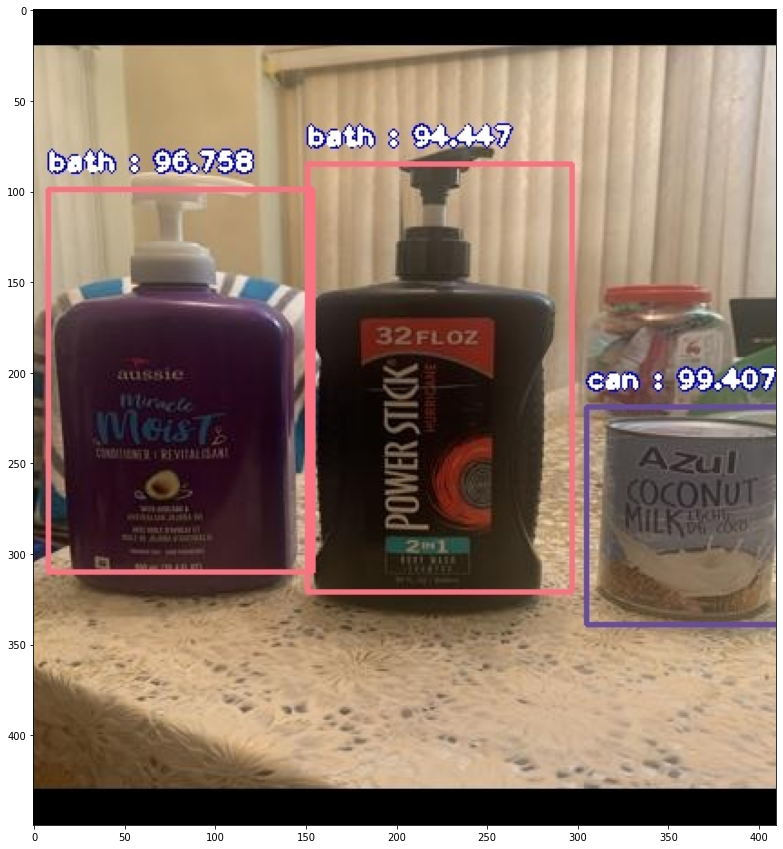

In [53]:

img = cv.imread("ima-detected.jpg")
img_cvt=cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.figure (figsize = (15,15))
plt.imshow(img_cvt)
plt.show()

In [57]:
detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()

# Use the model path with highest performance
detector.setModelPath("/content/detection_model-ex-011--loss-0033.636.h5")
detector.setJsonPath("/content/detection_config (2).json")
detector.loadModel()
detections = detector.detectObjectsFromImage (input_image ="/content/Detection/Conversion Demo/Tunistra/IMG_2844.JPG", output_image_path = "./ima-detected.jpg",minimum_percentage_probability = 60)

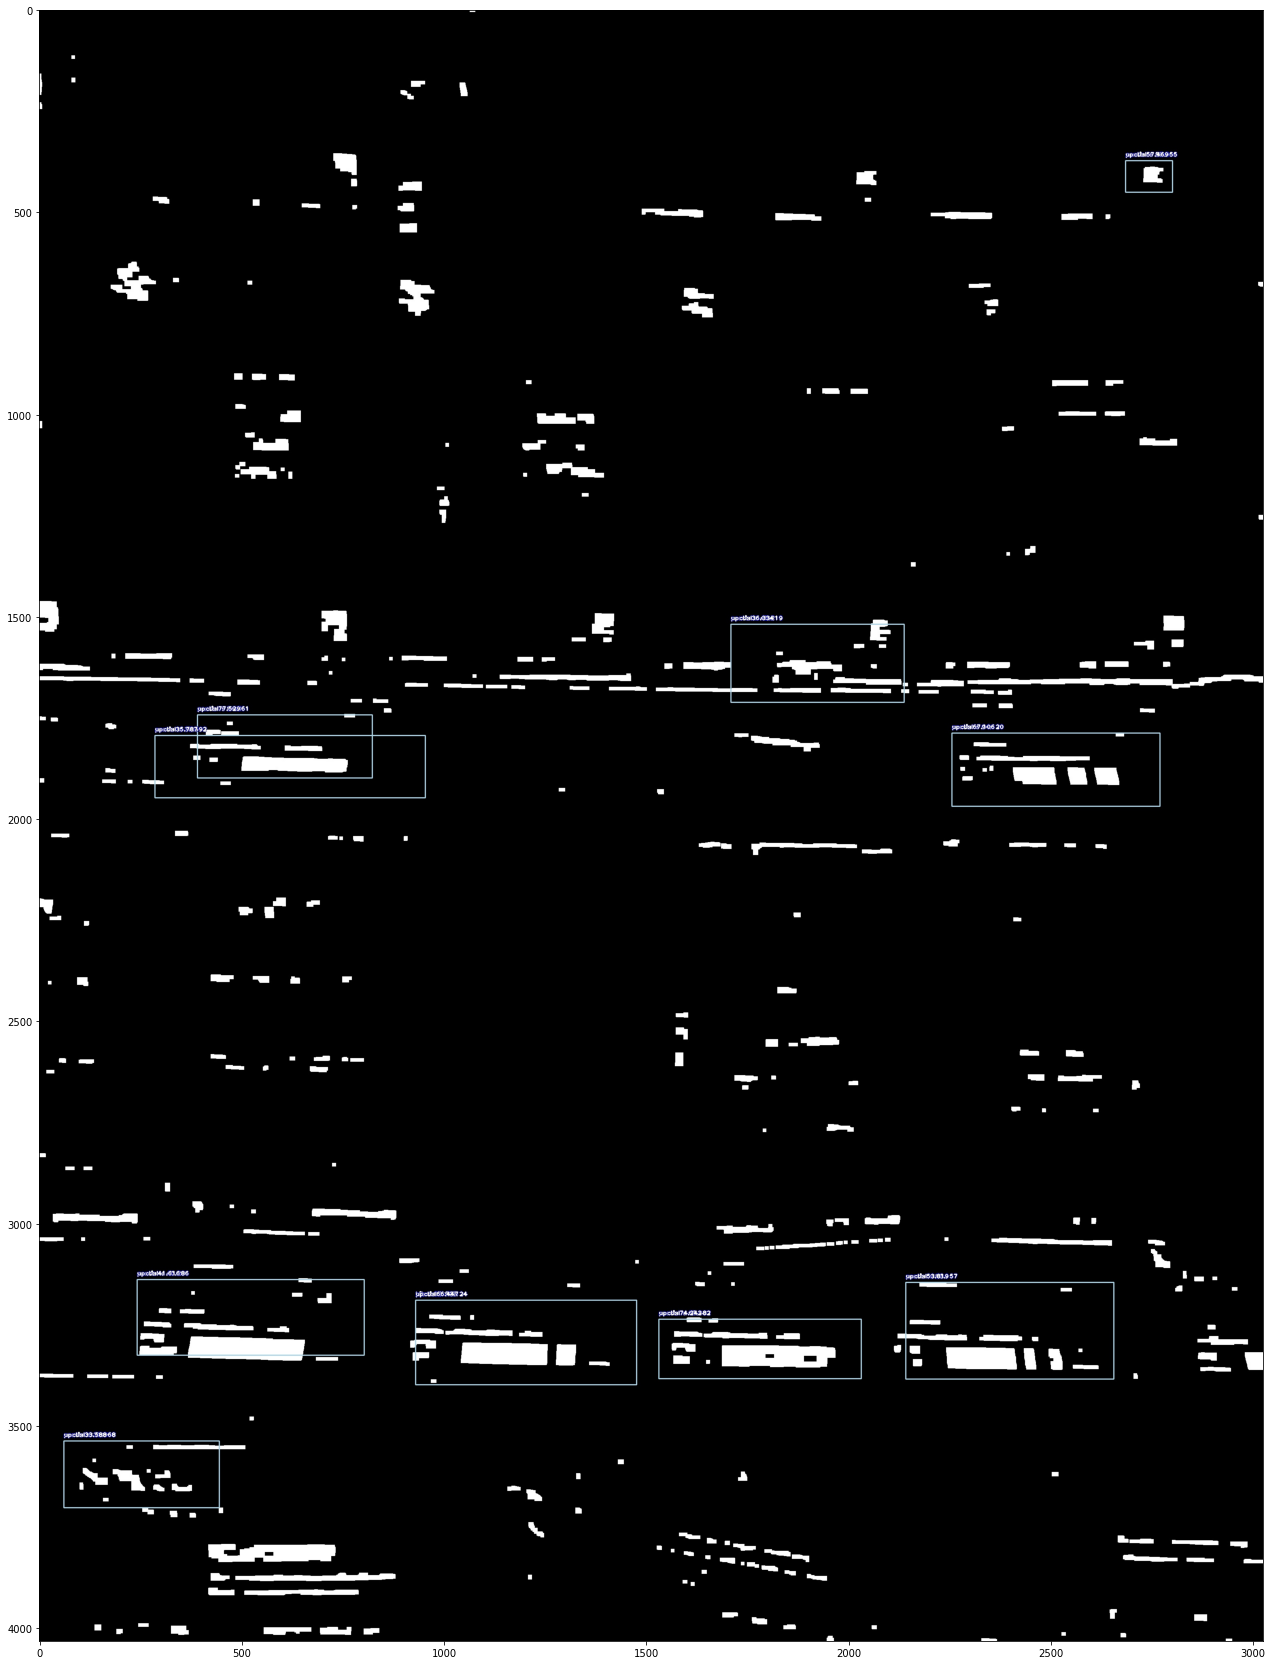

In [56]:
img = cv.imread("ima-detected.jpg")
img_cvt=cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.figure (figsize = (20,20))
plt.imshow(img_cvt)
plt.show()